In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import r2_score as r2

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
data = pd.read_csv('input/train.csv')

## Prepare Data

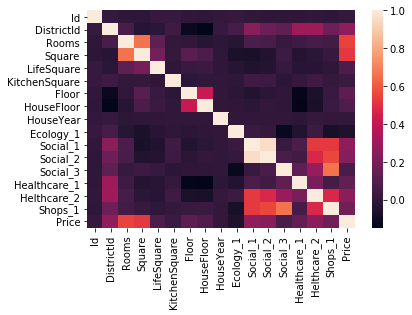

In [3]:
data_corr = data.corr()
sns.heatmap(data_corr);

In [4]:
high_corr = [column for column in data_corr['Price'] if column > 0.4 and column < 1]
high_corr

[0.5502907269258719, 0.5200745028416486]

Columns with correlation - DistrictId, Rooms, Square, Social_1, Social_2, Floor

In [5]:
data.loc[data['HouseYear'] > 2020, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [6]:
mean_year = np.round(data.loc[data['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1985.0

In [7]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [8]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square']*0.85

In [9]:
def set_rooms(df):
    df.loc[df['Rooms'] > 5, 'Rooms'] = round(df['Square']/25)

In [10]:
def prepare_data(df, mean_year=mean_year):
    clean_year(df, mean_year)
    clean_life_square(df)
    set_rooms(df)

In [11]:
prepare_data(data)

#### train_test_split

In [12]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [13]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9069,14604,23,1.0,41.681380,22.796166,8.0,14,17.0,2015.0,0.075779,B,B,6,1437,3,NaN,0,2,B,88504.384965
2603,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977.0,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663
7738,235,87,1.0,39.710131,19.538663,8.0,4,17.0,1986.0,0.100456,B,B,43,7227,0,NaN,1,6,A,182126.280899
1579,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017.0,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
5058,10773,77,3.0,79.195825,44.421062,10.0,16,17.0,1984.0,0.298205,B,B,16,4048,3,NaN,1,3,B,322048.433990


In [14]:
train.groupby('DistrictId', as_index=False)[['Price']].mean().sort_values('Price', ascending=False).head()

,DistrictId,Price
189,190,516137.070651
198,202,502085.860162
194,195,482791.138606
180,181,477217.801361
181,182,471000.007453


In [15]:
np.random.seed(42)

In [16]:
train['Price_n'] = train['Price'] + 5000*np.random.randn(train.shape[0]) * (train['Rooms'] + 1)

In [17]:
mean_price = train.groupby(['DistrictId', 'Rooms'], as_index=False)[['Price_n']].mean().\
rename(columns={'Price_n':'mean_price'})
mean_price.head()

,DistrictId,Rooms,mean_price
0,0,1.0,139085.130239
1,0,2.0,192533.321516
2,0,3.0,283993.875029
3,1,1.0,147209.801981
4,1,2.0,197104.291159


In [18]:
mean_price2 = train.groupby('Rooms', as_index=False)[['Price_n']].mean().\
    rename(columns={'Price_n':'mean_price2'})

In [19]:
mean_price2

,Rooms,mean_price2
0,0.0,184698.447550
1,1.0,160015.854986
2,2.0,214799.960505
3,3.0,291766.759032
4,4.0,385431.669473
5,5.0,393137.231599


In [20]:
mean_price_all = train['Price_n'].mean()
mean_price_all

214424.09023358364

In [21]:
def add_mean_price(df, mean_price=mean_price, mean_price2=mean_price2):
    global mean_price_all
    df = pd.merge(df, mean_price2, on='Rooms', how='left')
    df['mean_price2'] = df['mean_price2'].fillna(mean_price_all)
    df = pd.merge(df, mean_price, on=['DistrictId', 'Rooms'], how='left')
    df['mean_price'] = df['mean_price'].fillna(df['mean_price2'])
    df = df.drop('mean_price2', axis=1)
    return df

In [22]:
train = add_mean_price(train)

In [23]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_n,mean_price
0,14604,23,1.0,41.681380,22.796166,8.0,14,17.0,2015.0,0.075779,B,B,6,1437,3,NaN,0,2,B,88504.384965,93471.526495,102127.194313
1,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977.0,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663,204242.670639,171871.557412
2,235,87,1.0,39.710131,19.538663,8.0,4,17.0,1986.0,0.100456,B,B,43,7227,0,NaN,1,6,A,182126.280899,188603.166280,171991.933871
3,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017.0,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705,554826.147834,385852.544243
4,10773,77,3.0,79.195825,44.421062,10.0,16,17.0,1984.0,0.298205,B,B,16,4048,3,NaN,1,3,B,322048.433990,317365.366496,256849.158485


In [24]:
valid = add_mean_price(valid)

#### Random Forest

In [25]:
feats = ['DistrictId', 'Square', 'Rooms', 'HouseYear', 'Social_1', 'Social_2', 'Floor', 'mean_price']

In [26]:
def evaluate_model(model, train, valid, metric, feats, target, max_depth):
    dtr = model(max_depth=max_depth)
    dtr.fit(train.loc[:, feats], train[target])
    y_pred_train = dtr.predict(train.loc[:, feats])
    y_pred_valid = dtr.predict(valid.loc[:, feats])
    metric_train = metric(train[target], y_pred_train)
    metric_valid = metric(valid[target], y_pred_valid)
    return metric_train, metric_valid

In [27]:
def check_param(min_value, max_value, model, train=train, valid=valid, metric=r2, feats=feats, 
                             target='Price'):
    max_depth_arr = []
    metric_train_arr = []
    metric_valid_arr = []

    for i in range(min_value, max_value+1):
        res = evaluate_model(model, train, valid, metric, feats, 
                             target, max_depth=i)
        max_depth_arr.append(i)
        metric_train_arr.append(res[0])
        metric_valid_arr.append(res[1])
    return max_depth_arr, metric_train_arr, metric_valid_arr

In [37]:
max_depth_arr, metric_train_arr, metric_valid_arr = check_param(min_value=1, max_value=14, model=RFR)

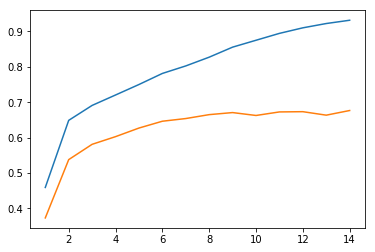

In [38]:
plt.plot(max_depth_arr, metric_train_arr)
plt.plot(max_depth_arr, metric_valid_arr)

In [39]:
model = RFR(max_depth=14, random_state=42, n_estimators=1000)

In [40]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
y_pred_train = model.predict(train.loc[:, feats])
y_pred_valid = model.predict(valid.loc[:, feats])
metric_train = r2(train['Price'], y_pred_train)
metric_valid = r2(valid['Price'], y_pred_valid)

In [42]:
np.max(metric_valid)

0.68949974263345

#### Test

In [43]:
test = pd.read_csv('input/test.csv')

In [44]:
test = add_mean_price(test)

In [45]:
test['Price'] = model.predict(test.loc[:, feats])

In [46]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,mean_price,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,171314.682416,159764.121729
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,238115.911682,241287.746258
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,160015.854986,109731.918439
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,202673.102421,268321.416284
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,123143.537105,144142.716573


In [47]:
test.loc[:, ['Id', 'Price']].to_csv('OOdegova_predictions.csv', index=None)